In [2]:
import numpy as np

import matplotlib.pyplot as plt


from scipy.signal import savgol_filter, find_peaks
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d

import os





In [3]:
# --------- File loading and preprocessing ---------

# Path to filtered respiration data files and list of bad channels
output_folder = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\png"
os.makedirs(output_folder, exist_ok=True)  # creates folder if it doesn't exist



PigCSVDataPathList = []
folder_path = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV"
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        PigCSVDataPathList.append(file_path)

for i,name in enumerate(PigCSVDataPathList):
    print(str(i) + ' '+ name)


0 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EndoPacingSite-LV-Apex.csv
1 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EndoPacingSite-RA.csv
2 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EndoPacingSite-RV-Apex.csv
3 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EndoPacingSite-RV-OutflowTract.csv
4 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EndoPacingSite-RV-Septum.csv
5 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-12.csv
6 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-131.csv
7 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-147.csv
8 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-149.csv
9 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-156.csv
10 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\SignalsCSV\EpiPacingSite-158.csv
11 C:\Users\emir.ege-nemutlu\Desktop\resp\Pig\Pig2\Signal

In [4]:

filepath = PigCSVDataPathList[5]
filename = filepath

# Load the filtered signal from CSV and transpose it
df = pd.read_csv(filename, sep=',')
df = df.T  # Rows become channels, columns become time samples //// I belive this might be vice versa

# List of bad leads (channels to exclude from analysis)
#Badlead_Ve = [1,15,	16,	25,	46,	53,	71,	72,	74,	78,	84,	96,	97, 105, 152, 153,]

# Remove bad leads from the dataframe
#df.drop(Badlead_Ve, axis=1, inplace=True)

# Create a time vector assuming a sampling rate of 2048 Hz
time = np.linspace(0, df[0].size / 2048, df[0].size)


In [5]:
min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 2048.0     # Sampling rate in Hz

peak_counts = []
ecgleads = []

for lead in df.columns:
    y = df[lead][:].copy().to_numpy()  # Get the signal
    ecgleads.append(y)

    # Detect peaks
    peaks, _ = find_peaks(
    y, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(y)  # absouute minthreshold
    )
    troughs, _ = find_peaks(
    -y, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(y)  # absouute minthreshold
    )

    if (len(peaks)>0 and len(troughs)>0):
    # Store number of detected peaks
        peak_counts.append(len(peaks))
        ecgleads.append(y)
# Find the index of the lead with median number of peaks
median_index = np.argsort(peak_counts)[(len(peak_counts)*3 // 4)]
median_ecg_signal = ecgleads[median_index]
print(df.columns[median_index])
print(np.argsort(peak_counts))

95
[  7  55  42  39  64  36   6   5  32  49  63  38  30  31  62  48  54  35
  34  37  41   4  53  45  50  51  44  61  58  59  52  60  33   9  40  46
  16  47 100  43  23   3  98  57  99   2  97  96  94  72  82  83  84  91
  90  89  69  70  79  73  71  81  93  92  80  88  78  74   1  29  22  28
  68   8  27  95  56  24  25  26  20  15  13  14  11  10   0  12  17  21
  18  19  76  77  75  67  66  86  85  65  87]


8
24


C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_25484\3503927470.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_low_peaks], x[time_low_peaks], "o")  # Troughs
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_25484\3503927470.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_high_peaks], x[time_high_peaks], "x")  # Peaks


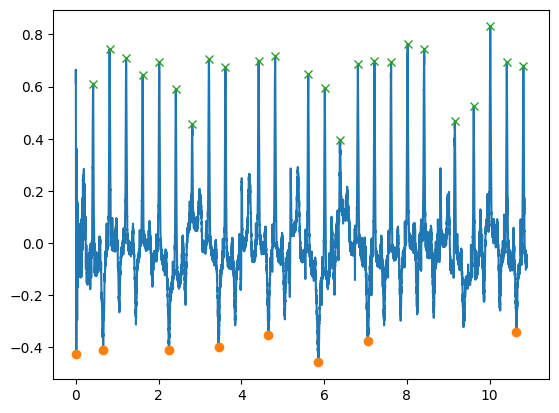

(24,)


In [6]:
# Select channel number 2 (e.g., one ECG lead) from the dataframe
n_ecg = 41
x = df[n_ecg][:].copy()  # Make a copy of the signal for processing

# Define parameters for peak detection
min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
sampling_rate = 2048.0     # Sampling rate in Hz

# Detect negative peaks (likely R-troughs in ECG) with minimum prominence and spacing
time_low_peaks, _ = find_peaks(
    -x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# Detect positive peaks (likely R-peaks in ECG)
time_high_peaks, _ = find_peaks(
    x, 
    prominence=0.1, 
    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# Ensure the signal starts with a low peak (trough)
if time_low_peaks[0] > time_high_peaks[0]:  
    time_high_peaks = time_high_peaks[1:]  # Remove first high peak if it occurs before the first trough
    print("first high_peaks removed")

# Ensure the signal ends with a high peak
if time_low_peaks[-1] > time_high_peaks[-1]:
    print("last low_peaks removed")
    time_low_peaks = time_low_peaks[:-1]  # Remove last low peak if it occurs after the last high peak

# Debug: print number of detected peaks
print(len(time_low_peaks))
print(len(time_high_peaks))

# Plot the ECG signal with detected peaks
plt.plot(time, x)  # Raw signal
plt.plot(time[time_low_peaks], x[time_low_peaks], "o")  # Troughs
plt.plot(time[time_high_peaks], x[time_high_peaks], "x")  # Peaks
plt.show()
print(time_high_peaks.shape)

In [8]:
print(time)

[0.00000000e+00 4.88303129e-04 9.76606259e-04 ... 1.08964843e+01
 1.08969726e+01 1.08974609e+01]


In [161]:
varlist = []
for i in df.columns.tolist():
    n_ecg = i
    x = df[n_ecg][:].copy()  # Make a copy of the signal for processing

    # Define parameters for peak detection
    min_distance_qrs_ms = 300  # Minimum time between two QRS complexes (in ms)
    sampling_rate = 2048.0     # Sampling rate in Hz
    # Detect positive peaks (likely R-peaks in ECG)
    time_high_peaks, _ = find_peaks(
        x, 
        prominence=0.1, 
        distance=min_distance_qrs_ms / 1000 * sampling_rate,
        height=0.4 * np.max(x)  # seuil minimum en valeur absolue
    )
    varlist.append((np.var(x.iloc[time_high_peaks]),i))

print(time_high_peaks.shape)


(17,)


In [162]:
vararray = np.array(varlist)
sorted_arr = vararray[np.argsort(vararray[:, 0])]
cutoffbottom = 0.4
cutofftop = 0.2

n = len(sorted_arr)

bot_index = int(n * (cutoffbottom))  
top_index = int(n * (cutofftop))
top_half = sorted_arr[top_index:bot_index]
top_half = np.sort(top_half[:, 1].astype(int))
print(top_half)
selected_columns = df[top_half]

[  2   4  16  17  18  20  23  24  27  28  32  37  41  49  65  74  83 102
 108 110 111 112 118 119 121 128 131 138 146 147]


In [163]:
selected_columns.shape

(22318, 30)

In [164]:
# Define the number of points corresponding to a 60ms window
# 50 samples at 2048 Hz ≈ 50 milliseconds
nPoint50ms = int(50 * 2048 / 1000)

# Assign the signal dataframe to a new variable
signals = selected_columns

# Ensure that rows are channels and columns are time samples
if signals.shape[1] < signals.shape[0]:
    signals = signals.T

# Convert the DataFrame to a NumPy array of floats for numerical operations
signals = signals.to_numpy(dtype=float)

# Initialize matrix to store RR amplitudes:
# Shape = (60 channels × number of R-peaks)
RRAmplitude = np.zeros((signals.shape[0], len(time_high_peaks)))

# Initialize a placeholder vector for PCA projection (3D)
vector = np.zeros((3, len(time_high_peaks)))

# Restrict the signal matrix to the first 60 channels

# Loop through each detected R-peak (time_high_peaks)
for iPeak, localPeak in enumerate(time_high_peaks):
    
    # For each channel, get the max absolute value in a ±60ms window around the peak
    localMax = [
        np.abs(sig[max(localPeak - nPoint50ms,0) : min(localPeak + nPoint50ms,len(sig))]).max() #has my fix
        for sig in signals
    ]
       # Store the amplitudes in the corresponding column
    RRAmplitude[:, iPeak] = localMax[0:(signals.shape[0])]

# Create a processing pipeline:
# 1. Standardize features across channels
# 2. Apply PCA to reduce to 3 components
pca = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=3))
])
print(RRAmplitude.shape)
# Fit PCA on the transposed RRAmplitude (features in columns) and transform the data
pca_RRamp = pca.fit_transform(RRAmplitude.T)

(30, 17)


(-1.0, 1.0)

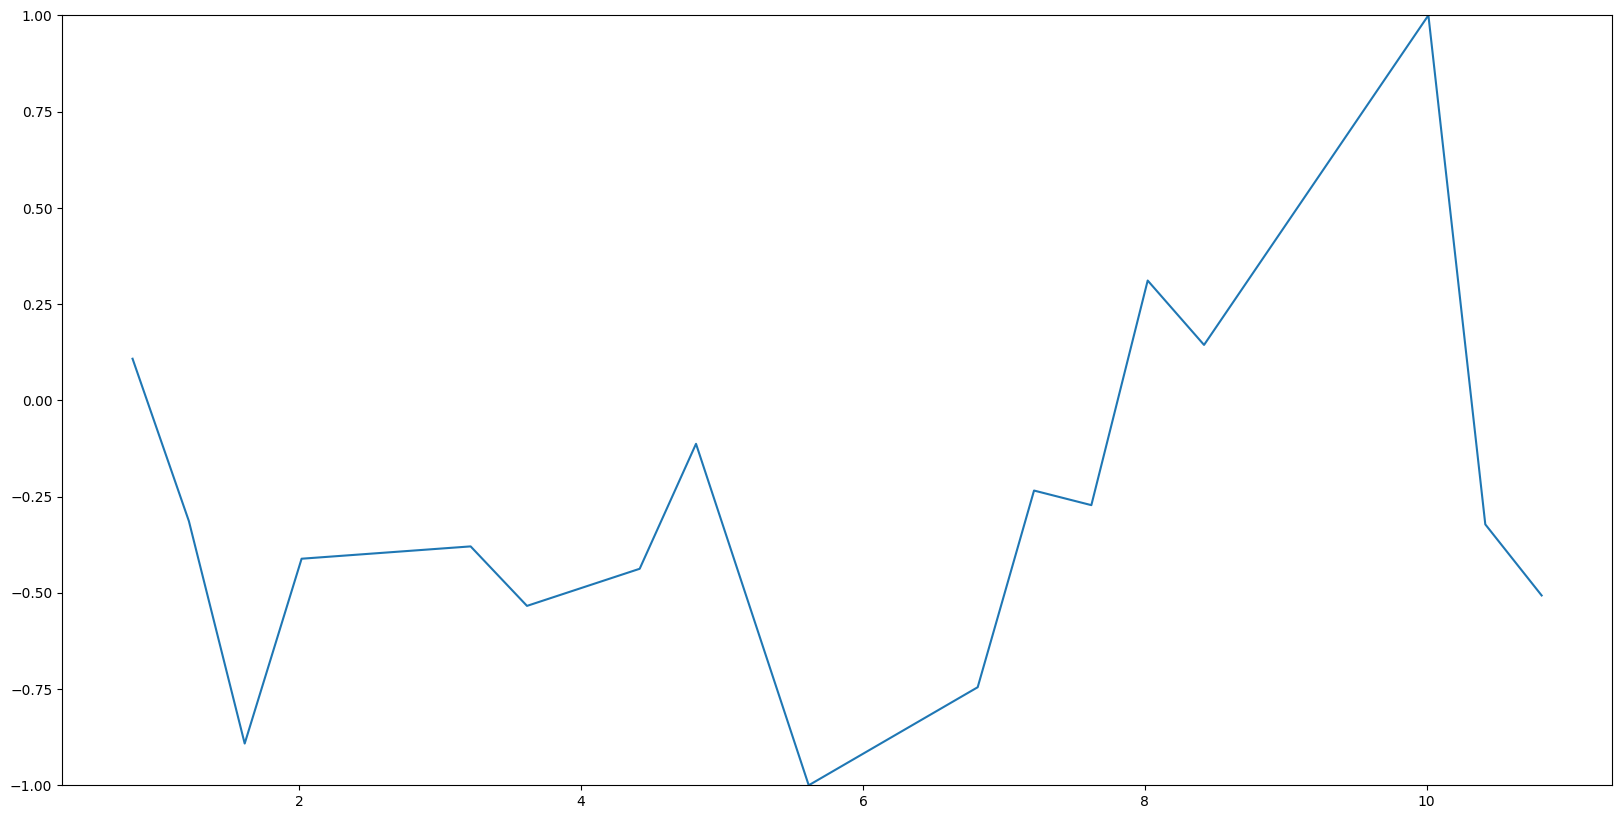

In [165]:
# Select which PCA component to use (e.g., 0 = first principal component)
n_component = 0

# Normalize the selected PCA component to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
pca_RRamp_normalized = scaler.fit_transform(
    pca_RRamp[:, n_component].reshape(-1, 1)  # Reshape to 2D for scaler
).flatten()  # Flatten back to 1D after scaling

# Create a large figure and plotting axis
ax = plt.figure(figsize=[20, 10]).subplots()

# Plot the normalized PCA projection against the time of R-peaks
ax.plot(time[time_high_peaks], pca_RRamp_normalized)

# Set Y-axis limits to match the normalization range
ax.set_ylim([-1, 1])


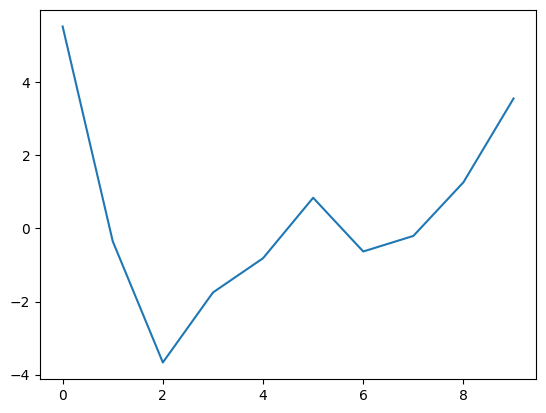

In [ ]:
reference_track = savgol_filter(pca_RRamp[:,n_component], window_length=6, polyorder=2)
plt.plot(reference_track)

In [ ]:
# Create time vector corresponding to PCA values (at each R-peak)
time_reference = time[time_high_peaks]

# Create an interpolation function to reconstruct a continuous signal
interp_func = interp1d(
    time_reference,         # Known time points (where PCA was computed)
    reference_track,        # Corresponding PCA values
    kind='linear',          # Interpolation type: 'linear' 
    fill_value="extrapolate"  # Allow extrapolation beyond the last known time point
)

# Use the original time vector at full sampling rate (2048 Hz)
time_full = time  # Already defined earlier using np.linspace(...)

# Interpolate (resample) the PCA signal at the full resolution of the original signal
reference_resampled = interp_func(time_full)

In [ ]:
def select_peaks_near_extreme_amplitude(part, time_high_peaks, amplitude_percent=0.2):
    """
    Identify R-peaks that fall within ±20% of the amplitude near respiratory peaks and troughs.

    Parameters:
        part: 1D numpy array
            The respiratory signal (e.g., PCA-resampled respiration).
        time_high_peaks: list or array
            Indices of R-peaks to classify.
        amplitude_percent: float
            The proportion of the peak-to-trough amplitude to define the zone (default = 20%).

    Returns:
        df_top: DataFrame of R-peaks near the top 20% amplitude
        df_bottom: DataFrame of R-peaks near the bottom 20% amplitude
        df_outside: DataFrame of R-peaks outside the 20% amplitude zones
    """

    # Normalize the respiratory signal to [0, 1] range
    scaler = MinMaxScaler()
    resp_norm = scaler.fit_transform(part.reshape(-1, 1)).flatten()

    # Detect peaks (maxima) and troughs (minima) in the respiration
    peaks, _ = find_peaks(resp_norm, prominence=0.3, distance=500)
    troughs, _ = find_peaks(-resp_norm, prominence=0.3, distance=500)

    # Lists to collect R-peaks
    rpeaks_top = []
    rpeaks_bottom = []
    rpeaks_outside = []

    # Plot the normalized respiratory signal
    plt.figure(figsize=(20, 6))
    plt.plot(resp_norm, label="Normalized Respiration")
    plt.scatter(peaks, resp_norm[peaks], c='red', label='Peaks')
    plt.scatter(troughs, resp_norm[troughs], c='blue', label='Troughs')

    for rpeak in time_high_peaks:
        if len(peaks) == 0 or len(troughs) == 0:
            continue

        # Find closest peak and trough
        closest_peak = peaks[np.argmin(np.abs(peaks - rpeak))]
        closest_trough = troughs[np.argmin(np.abs(troughs - rpeak))]

        # Determine local amplitude range
        amp = resp_norm[closest_peak] - resp_norm[closest_trough]

        if abs(closest_peak - rpeak) < abs(closest_trough - rpeak):
            # Closer to peak → top zone
            threshold = resp_norm[closest_peak] - amplitude_percent * amp
            if resp_norm[rpeak] >= threshold:
                rpeaks_top.append(rpeak)
                plt.axhspan(threshold, 1, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='green', alpha=0.2, label='Top ±20% amp' if len(rpeaks_top) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)
        else:
            # Closer to trough → bottom zone
            threshold = resp_norm[closest_trough] + amplitude_percent * amp
            if resp_norm[rpeak] <= threshold:
                rpeaks_bottom.append(rpeak)
                plt.axhspan(0, threshold, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='purple', alpha=0.2, label='Bottom ±20% amp' if len(rpeaks_bottom) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)

    # Plot classified R-peaks
    plt.scatter(rpeaks_top, resp_norm[rpeaks_top], c='darkgreen', label='R-peaks top 20% amplitude')
    plt.scatter(rpeaks_bottom, resp_norm[rpeaks_bottom], c='indigo', label='R-peaks bottom 20% amplitude')
    plt.scatter(rpeaks_outside, resp_norm[rpeaks_outside], c='r', label='R-peaks outside 20% zones')

    plt.title("R-peaks within ±20% amplitude zones near respiratory extremes")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig(os.path.join( folder_path,'png', os.path.basename(filepath).split('.')[0]+'.png'), dpi=300, bbox_inches='tight')

    df_top = pd.DataFrame(sorted(set(rpeaks_top)), columns=['rpeaks_top_20_amp'])
    df_bottom = pd.DataFrame(sorted(set(rpeaks_bottom)), columns=['rpeaks_bottom_20_amp'])
    df_outside = pd.DataFrame(sorted(set(rpeaks_outside)), columns=['rpeaks_outside'])

    return df_top, df_bottom, df_outside


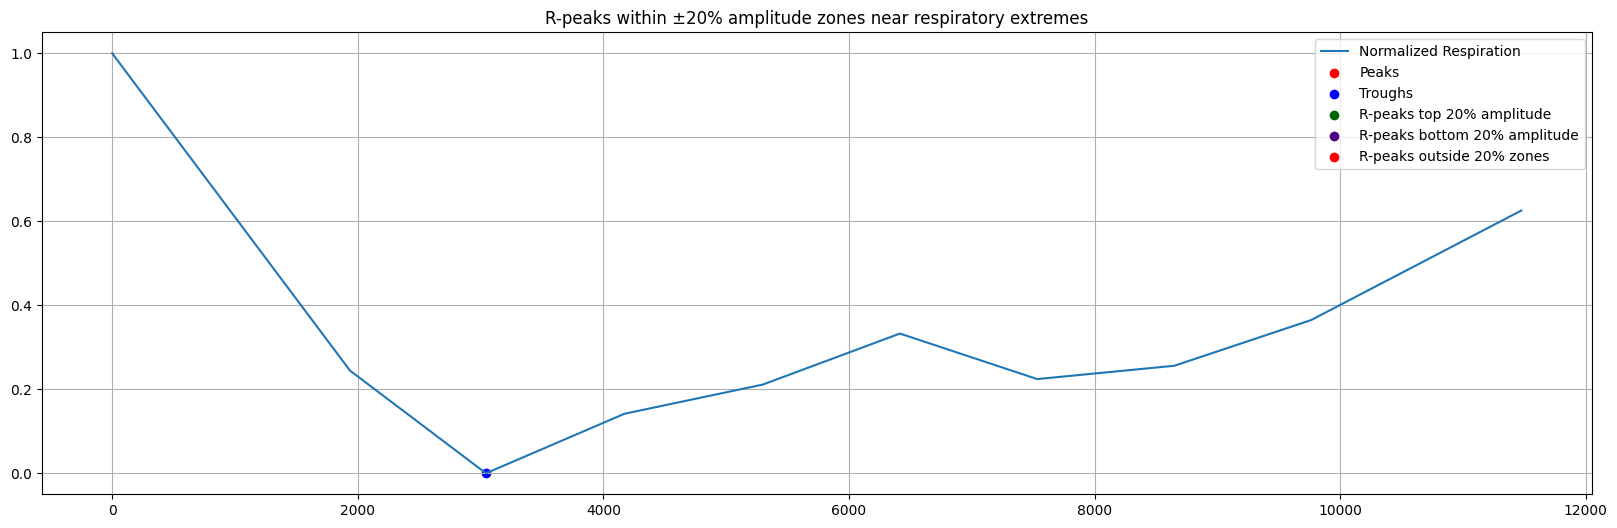

<Figure size 640x480 with 0 Axes>

In [ ]:
df_top, df_bottom, df_outside = select_peaks_near_extreme_amplitude(reference_resampled, time_high_peaks, 0.20)

In [ ]:
print(df_top)

   rpeaks_top_20_amp
0               4802
1               5622
2               6449
3              13819


In [ ]:
os.path.join( folder_path,'png', os.path.basename(filepath).split('.')[0]+'.png')


'C:\\Users\\emir.ege-nemutlu\\Desktop\\resp\\Pig\\Pig1\\SignalsCSV\\png\\EndoPacingSite-LV-Apex.png'

In [ ]:
# Set parameters
sampling_rate = 2048.0  # Hz
min_distance_qrs_ms = 300  # ms
min_distance_samples = int(min_distance_qrs_ms / 1000 * sampling_rate)

# Store peak counts and signals
peak_counts = []
ecgleads = []

# Loop over all leads (columns)
for lead in df.columns:
    x = df[lead][:].copy().to_numpy()  # Get the signal
    ecgleads.append(x)

    # Detect peaks
    peaks, _ = find_peaks(
        x,
        prominence=0.1,
        distance=min_distance_samples,
        height=0.4 * np.max(x)
    )

    # Store number of detected peaks
    peak_counts.append(len(peaks))

# Find the index of the lead with median number of peaks
median_index = np.argsort(peak_counts)[len(peak_counts) // 2]
median_ecg_signal = ecgleads[median_index]

median_lead_name = df.columns[median_index]



Selected median ECG lead: 48
